# Nano Project - Monte Carlo Estimation of the Delta in the Black-Scholes Model

## Objective

In this exercise, we aim to **compare two Monte Carlo estimators of the Delta** of a European option in the Black–Scholes model.  
Both estimators are theoretically unbiased, but their **variances** behave differently depending on the **time to maturity** $T$.

We will **verify numerically** the variance for both estimators for **short maturities** and **long maturities**.

## 1. Theoretical Background

We consider the **Black–Scholes model**:

$$
dX_t = r X_t \, dt + \sigma X_t \, dW_t, \quad X_0 = x
$$

whose solution is:

$$
X_T = x \, e^{(r - \frac{1}{2}\sigma^2)T + \sigma W_T}
$$

Let the **payoff** be $\phi(X_T)$ (e.g. a call: $\phi(x) = (x - K)^+$).

The **price function** is:

$$
u(x) = \mathbb{E}\left[ e^{-rT} \phi(X_T^x) \right]
$$

and the **Delta** (sensitivity of the price with respect to $x$) is:

$$
\Delta(x) = \frac{\partial u}{\partial x}
$$

## 2. Two Monte Carlo Estimators for Delta

### (a) Pathwise Derivative Method

If $\phi$ is differentiable outside a countable set and locally Lipschitz with polynomial growth, we can write:

$$
\Delta_1(x) = \mathbb{E}\left[ e^{-rT} \phi'(X_T^x) \frac{X_T^x}{x} \right]
$$

### (b) Likelihood Ratio (Score Function) Method

We can obtain an alternative formula:

$$
\Delta_2(x) = \mathbb{E}\left[ e^{-rT} \phi(X_T^x) \frac{W_T}{x \sigma T} \right]
$$


Voici un bloc prêt à être copié-collé dans une cellule **Markdown** de ton Jupyter Notebook. Il intègre toutes les corrections et nuances discutées (biais, maturité, nature du payoff).


## 4. Simulation Setup

We simulate under the following parameters:

| Parameter | Symbol | Example Value |
|------------|---------|----------------|
| Initial price | $x_0$ | 100 |
| Strike | $K$ | 95, 98, 100, 102, 105 |
| Risk-free rate | $r$ | 0 |
| Volatility | $\sigma$ | 0.1, 0.2, 0.3 |
| Maturities | $T$ | 0.001 to 50 |


## 5. Implementation Outline

We will:

1. Simulate $W_T \sim \mathcal{N}(0, T)$  
2. Compute $X_T = x e^{(r - \frac{1}{2}\sigma^2)T + \sigma W_T}$  
3. Evaluate:
   - $\hat{\Delta}_1 = e^{-rT} \phi'(X_T) \frac{X_T}{x}$
   - $\hat{\Delta}_2 = e^{-rT} \phi(X_T) \frac{W_T}{x \sigma T}$
4. Estimate:
   - Empirical mean and variance of both estimators  
5. Compare the variances across maturities


## 6. Expected Conclusion

Based on theory and the Law of the Iterated Logarithm (LIL) for Brownian motion:

- As $T \to 0$:
  $$
  \operatorname{Var}(\hat{\Delta}_1) = O(1/T)
  \quad \text{and} \quad
  \operatorname{Var}(\hat{\Delta}_2) \to \infty
  $$

- As $T \to \infty$:
  $$
  \operatorname{Var}(\hat{\Delta}_1) \to \infty
  \quad \text{and} \quad
  \operatorname{Var}(\hat{\Delta}_2) \text{ stabilizes}
  $$

Therefore:
- **Pathwise method** → Best for **short maturities**  
- **Likelihood ratio method** → Best for **long maturities**

## Numerical Computation

### Black-Scholes Model Framework

In [97]:
import numpy as np
import math

def model_bs(r, S0, sigma, T):
    return {
        "r": r,
        "S0": S0,
        "sigma": sigma,
        "mu": r - 0.5 * sigma**2,
        "T": T,
        "actualization": math.exp(-r * T)
    }

### Generate Brownian Motion

In [98]:
# Generate Brownian Motion
from numpy.random import default_rng
rng = default_rng()

def BM(size, bs):
    # Generate standard normal variables
    B = rng.standard_normal((size,1))
    # Scale by sqrt(T)
    B = B * math.sqrt(bs["T"])
    return B

### Compute asset price $X_t$

In [99]:
def asset_prices(bs, B):
    S_T = bs["S0"] * np.exp(bs["mu"] * bs["T"] + bs["sigma"] * B)
    return S_T

### Payoff function and its derivative

In [100]:
def phi(S, K):
    return np.maximum(S-K, 0)

def phi_derivative(S, K):
    return (S > K).astype(float)

### First method : Pathwise Derivative Method

In [101]:
def sampling_delta_derivative(K, size, bs): 
    B = BM(size, bs)
    Sn = asset_prices(bs, B)
    return bs["actualization"] * phi_derivative(Sn, K) * Sn / bs["S0"]

### Second method : Likelihood Ratio

In [102]:
def sampling_delta_score(K,size,bs):
    B = BM(size, bs)
    Sn = asset_prices(bs, B)
    # B = sqrt(T) * Z, so B / sqrt(T) = Z
    # Likelihood ratio formula: phi(S_T) * Z / (sigma * S0 * sqrt(T))
    return bs["actualization"] * phi(Sn, K) * B / (bs["sigma"] * bs['T'] * bs["S0"])

### Monte Carlo Adaptative function

In [ ]:
import scipy.stats as sps
import time
from IPython.display import clear_output
from tqdm import tqdm

def monte_carlo_adaptive(sampling_function, bs, K, epsilon: float, 
                         batch_size: int = 100000, 
                         proba: float = 0.95) -> dict:
    """
    Performs an adaptive Monte Carlo estimation until the confidence interval 
    of the mean is smaller than epsilon.

    Args:
    - sampling_function (callable): A function that generates samples of a 
    given size passed as an argument.
    - epsilon (float): Maximum tolerated size for the confidence interval.
    - proba (float): Confidence level for the interval (default: 0.95).
    - batch_size (int): Batch size for the simulations.

    Returns:
    - dict: A dictionary containing the following values:
        - "mean" (float): Mean of the final sample.
        - "var" (float): Variance of the final sample.
        - "ci_size" (float): Size of the confidence interval.
        - "samples_size" (int): Number of draws performed.
        - "time (s)" (float): Execution time in seconds.
    """

    clear_output(wait=True)
    
    alpha = 1 - proba
    quantile = sps.norm.ppf(1 - alpha / 2)

    sum_, sum2_, size_ = 0, 0, 0
    start = time.time()
    with tqdm(total=None, desc="Adaptive Monte Carlo") as pbar:
        while True:
            # new batch of samples
            samples = sampling_function(K, batch_size, bs)
            sum_ += samples.sum().item()
            sum2_ += (samples**2).sum().item()
            size_ += batch_size

            mean = sum_ / size_
            var = size_ / (size_-1) * (sum2_ / size_ - mean**2)
            ci_size = 2 * quantile * math.sqrt(var / size_)
    
            # update progress bar 
            pbar.set_postfix({"IC_size": ci_size, "mean": mean, "var": var})
            pbar.update(batch_size)

            if ci_size <= epsilon:
                break
    stop = time.time()
    return {
        "mean": mean,
        "var": var,
        "ci_size": ci_size,
        "samples_size": size_,
        "time (s)": stop-start,
    }

## Comparaison for different parameters

In [113]:
import pandas as pd
bss = []

for sigma in [0.5]:
    T_values = np.concatenate([
        np.linspace(0.001, 0.1, 20), # Small to medium T
        np.linspace(1, 20, 10),  # Medium T
        np.linspace(21, 50, 5)   # Large T
    ])
    for T in T_values:
        for sigma in [0.1, 0.2, 0.3]:
            bss.append(model_bs(r=0.0, S0=100,sigma=sigma,T=T))

# Comparaison for different parameters and save in a dataframe
results = []

for bs in bss:
    for K in [95,98, 100, 102, 105]:
        print(f"Processing sigma={bs['sigma']}, T={bs['T']}, K={K}")
        output_derivative = monte_carlo_adaptive(sampling_function=sampling_delta_derivative, bs=bs, K=K, epsilon=0.05, batch_size=1000000)
        output_score = monte_carlo_adaptive(sampling_function=sampling_delta_score, bs=bs, K=K, epsilon=0.05, batch_size=1000000)
        results.append({
            "sigma": bs["sigma"],
            "T": bs["T"],
            "K": K,
            "method": "derivative",
            **output_derivative
        })
        results.append({
            "sigma": bs["sigma"],
            "T": bs["T"],
            "K": K,
            "method": "score",
            **output_score
        })

df_results = pd.DataFrame(results)
df_results   

Adaptive Monte Carlo: 3000000it [00:00, 14029586.88it/s, IC_size=0.0398, mean=0.851, var=310]


,sigma,T,K,method,mean,var,ci_size,samples_size,time (s)
0,0.1,0.001,95,derivative,1.000003,0.000010,0.000012,1000000,0.081807
1,0.1,0.001,95,score,0.997146,252.110477,0.044011,2000000,0.144911
2,0.1,0.001,98,derivative,1.000004,0.000010,0.000012,1000000,0.072398
3,0.1,0.001,98,score,1.010820,42.095248,0.025433,1000000,0.072463
4,0.1,0.001,100,derivative,0.500689,0.251267,0.001965,1000000,0.061632
...,...,...,...,...,...,...,...,...,...
1045,0.3,50.000,100,score,0.855400,306.902761,0.039648,3000000,0.211347
1046,0.3,50.000,102,derivative,0.853742,68.371001,0.032413,1000000,0.068537
1047,0.3,50.000,102,score,0.849303,232.703173,0.042283,2000000,0.145110
1048,0.3,50.000,105,derivative,0.842520,81.458297,0.035379,1000000,0.078435


## Graphics

<>:30: SyntaxWarning: invalid escape sequence '\s'
<>:60: SyntaxWarning: invalid escape sequence '\s'
<>:30: SyntaxWarning: invalid escape sequence '\s'
<>:60: SyntaxWarning: invalid escape sequence '\s'
C:\Users\natha\AppData\Local\Temp\ipykernel_24588\980720584.py:30: SyntaxWarning: invalid escape sequence '\s'
  ax.set_title(f"$\sigma={sigma}$, $K={K}$", fontsize=12, fontweight='bold')
C:\Users\natha\AppData\Local\Temp\ipykernel_24588\980720584.py:60: SyntaxWarning: invalid escape sequence '\s'
  ax.set_title(f"$\sigma={sigma}$, $K={K}$", fontsize=12, fontweight='bold')


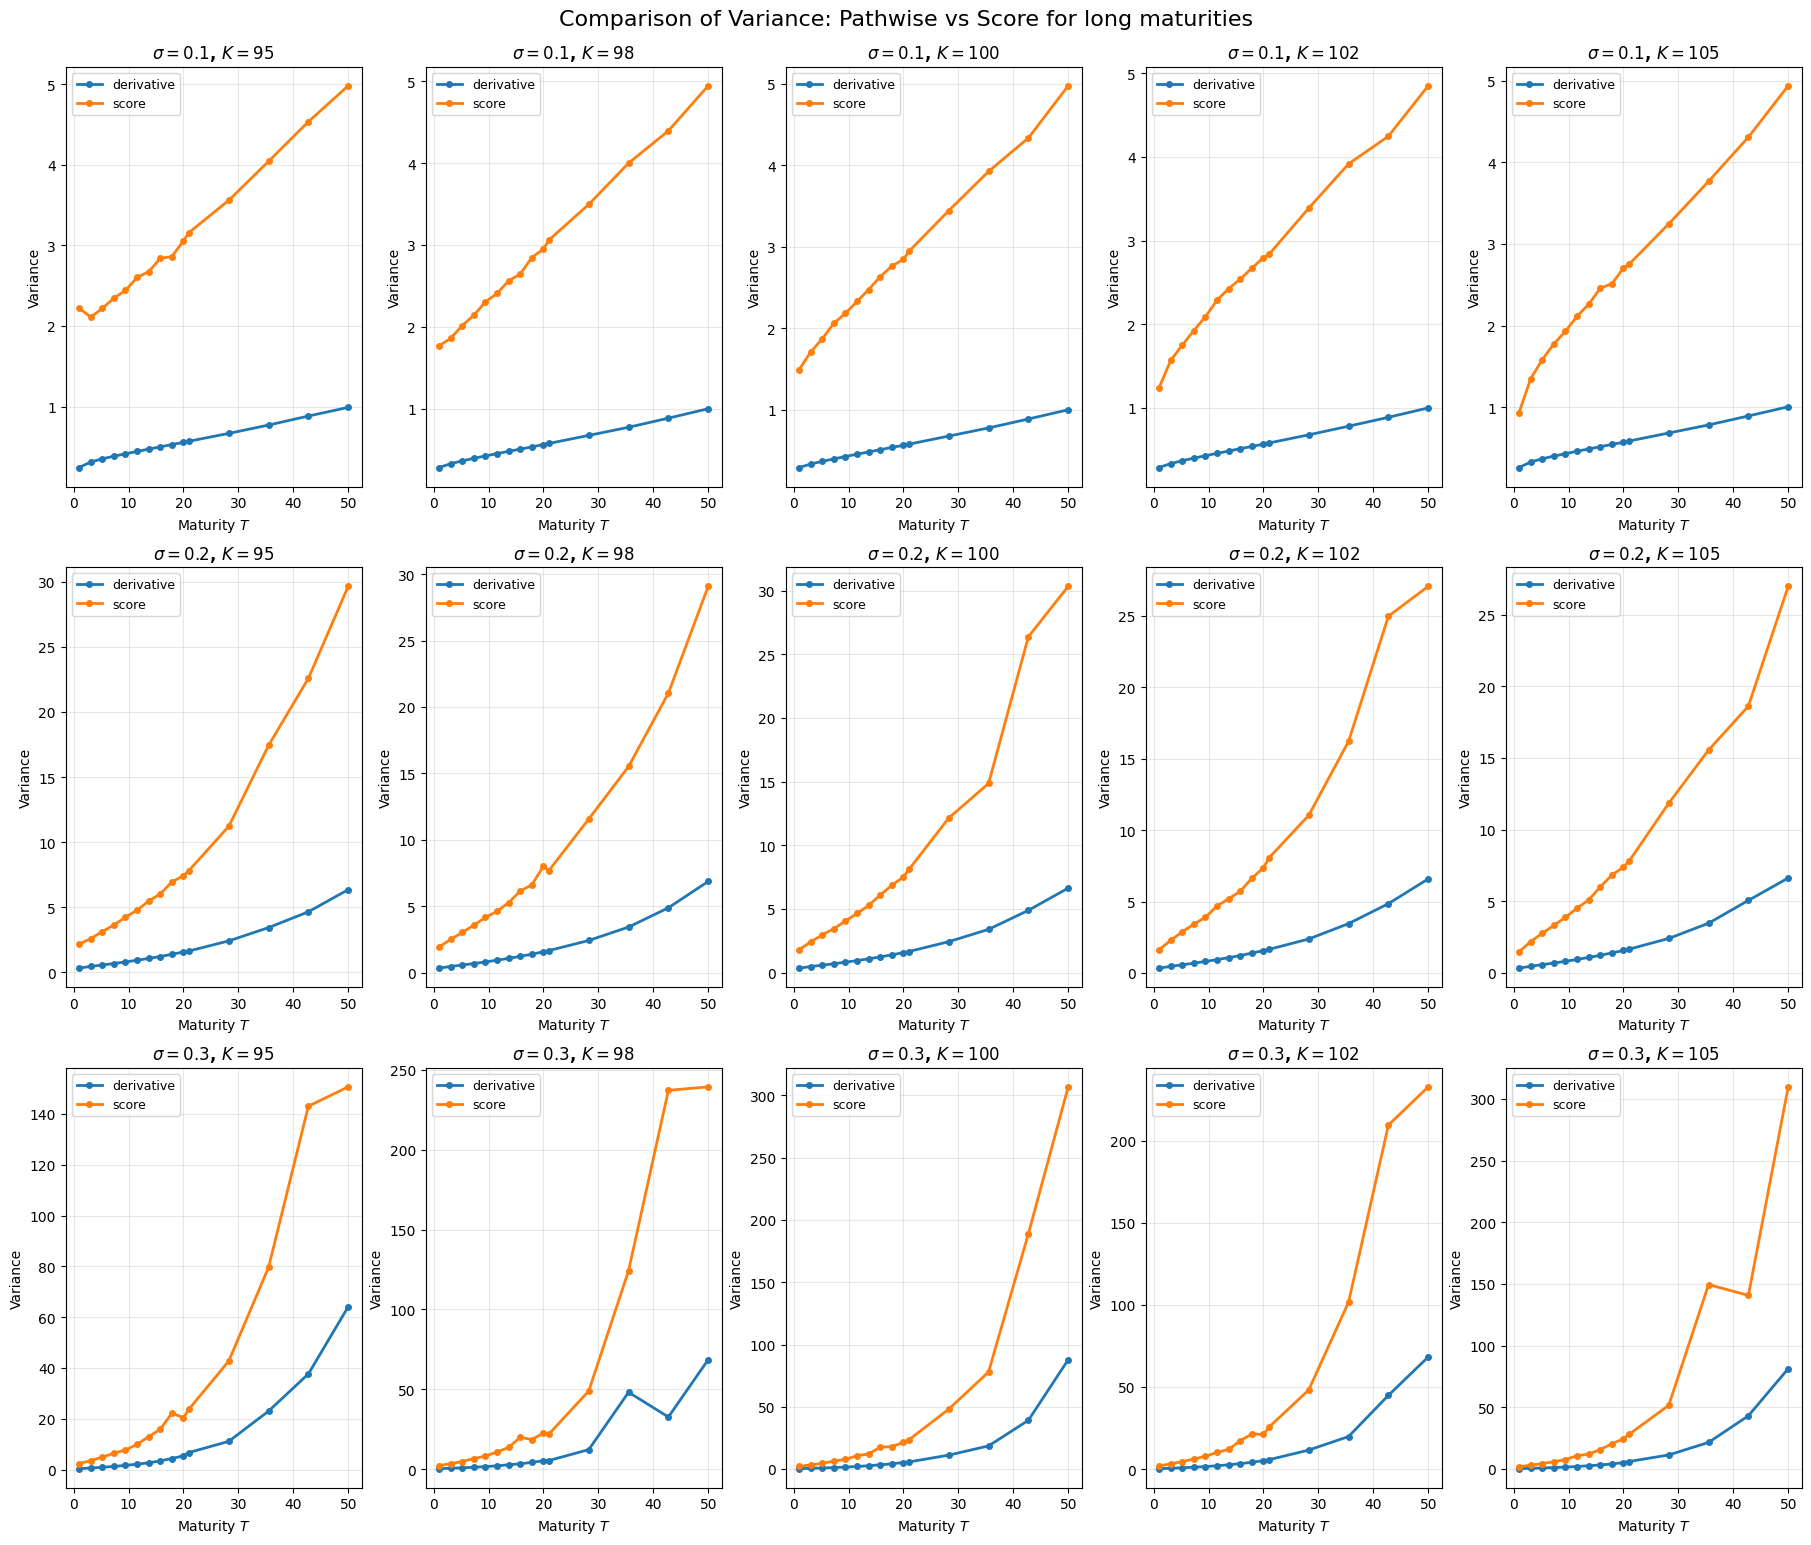

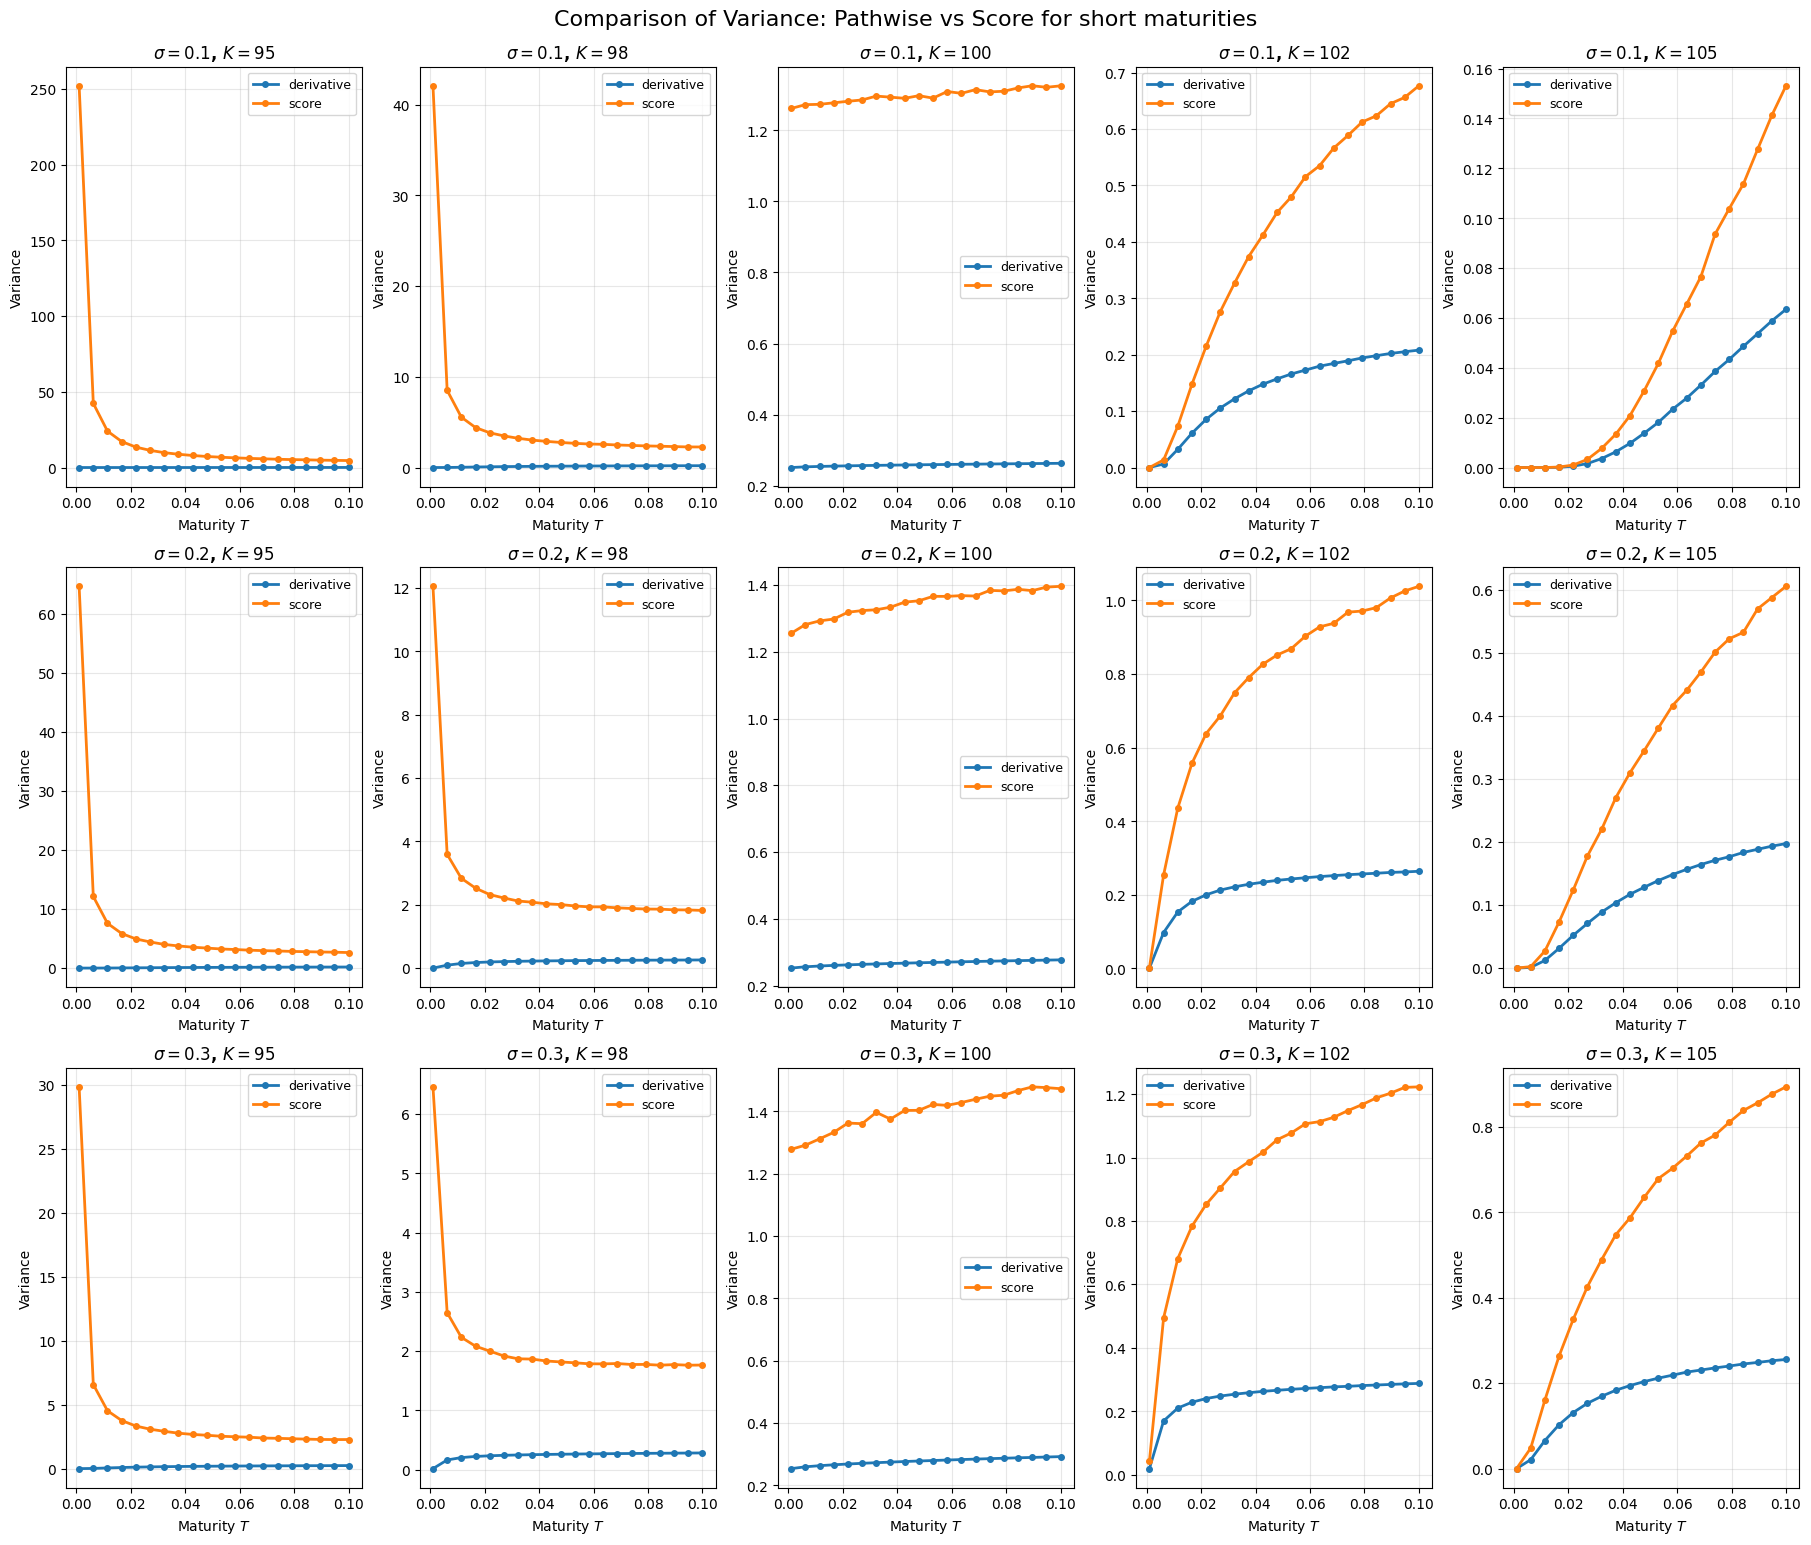

In [114]:
import matplotlib.pyplot as plt

# Params
sigmas = df_results["sigma"].unique()
Ks = [95, 98, 100, 102, 105]
scenarios = [(s, k) for s in sigmas for k in Ks]
n_plots = len(scenarios)

# Plotting grid for long maturities
n_cols = 5
n_rows = math.ceil(n_plots / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows), constrained_layout=True)

axes_flat = axes.flatten()

for i, (sigma, K) in enumerate(scenarios):
    ax = axes_flat[i]
    
    for method in df_results["method"].unique():
        # Filtering data
        subset = df_results[
            (df_results["sigma"] == sigma) & 
            (df_results["method"] == method) & 
            (df_results["K"] == K)
        ][20:]
        
        ax.plot(subset["T"], subset["var"], marker='o', label=method, linewidth=2, markersize=4)

    ax.set_title(f"$\sigma={sigma}$, $K={K}$", fontsize=12, fontweight='bold')
    ax.set_xlabel("Maturity $T$", fontsize=10)
    ax.set_ylabel("Variance", fontsize=10)
    ax.legend(fontsize=9)
    ax.grid(True, which="both", ls="-", alpha=0.3)

for j in range(i + 1, len(axes_flat)):
    fig.delaxes(axes_flat[j])

plt.suptitle("Comparison of Variance: Pathwise vs Score for long maturities", fontsize=16, y=1.02)
plt.show()

# Plotting grid for short maturities
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows), constrained_layout=True)

axes_flat = axes.flatten()

for i, (sigma, K) in enumerate(scenarios):
    ax = axes_flat[i]
    
    for method in df_results["method"].unique():
        # Filtering data
        subset = df_results[
            (df_results["sigma"] == sigma) & 
            (df_results["method"] == method) & 
            (df_results["K"] == K)
        ][:20]
        
        ax.plot(subset["T"], subset["var"], marker='o', label=method, linewidth=2, markersize=4)

    ax.set_title(f"$\sigma={sigma}$, $K={K}$", fontsize=12, fontweight='bold')
    ax.set_xlabel("Maturity $T$", fontsize=10)
    ax.set_ylabel("Variance", fontsize=10)
    ax.legend(fontsize=9)
    ax.grid(True, which="both", ls="-", alpha=0.3)

for j in range(i + 1, len(axes_flat)):
    fig.delaxes(axes_flat[j])

plt.suptitle("Comparison of Variance: Pathwise vs Score for short maturities", fontsize=16, y=1.02)
plt.show()

### Analysis of Simulation Results (Call Option)

The simulations highlight the distinct variance regimes for a Call option :

1.  **Short Maturities ($T \to 0$):**
    Consistent with the general theory, the **Score (Likelihood Ratio)** estimator (orange curve) is highly unstable, exhibiting an explosion in variance due to the $1/(\sigma T)$ singularity. The **Pathwise** estimator (blue curve) remains perfectly stable and efficient.

2.  **Long Maturities ($T \to 50$):**
    Tthe **Score** estimator performs **worse** than the Pathwise estimator even for long maturities.
    * **Reason:** The Call payoff is unbounded (it grows with $S_T$). In the Score method, this large payoff is multiplied by the score weight, amplifying the variance significantly as $T$ increases.
    * **Pathwise Advantage:** The derivative of a Call option is bounded ($\mathbb{1}_{S_T > K}$, i.e., 0 or 1). This "dampens" the exploding variance of the underlying asset $S_T$, keeping the estimator's variance much lower than that of the Score method.

**Conclusion:**
For **Call Options** (and other continuous, unbounded payoffs), the **Pathwise method** is uniformly superior. It offers lower variance across both short and long maturities compared to the Score method.

# Test with another payoff function

It seems that the score method is no efficient in the case of a simple call but can be useful when the derivative is not defined or when the payoff is bounded

### Digital Payoff Smoothing (Sigmoid Approximation)

To apply the **Pathwise method** to a discontinuous Digital option (which pays $1$ if $S_T > K$), we must smooth the discontinuity. We approximate the Heaviside step function using a **Sigmoid** function, where $x = S_T - K$ and $k$ controls the steepness.

#### 1. Smoothed Payoff Function
$$
g_k(x) = \frac{1}{1 + e^{-kx}}
$$
* **Behavior:** As $k \to \infty$, $g_k(x)$ converges to the indicator function $\mathbb{1}_{x>0}$.
* **Python:** `smooth_digital(x, k)`

#### 2. Derivative (for Pathwise Delta)
To compute the Pathwise estimator, we require the analytical derivative $g'_k(x)$. Using the quotient rule:
$$
g'_k(x) = \frac{k e^{-kx}}{(1 + e^{-kx})^2}
$$
* **Observation:** This derivative acts as a "bell curve" centered around $x=0$ (the strike), replacing the Dirac delta.
* **Python:** `smooth_digital_derivative(x, k)`

In [106]:
def smooth_digital(x, k=2):
    return 1 / (1 + np.exp(-k*x))

def smooth_digital_derivative(x, k=2):
    exp_term = np.exp(-k * x)
    return (k * exp_term) / (1 + exp_term)**2

In [115]:
def sampling_delta_derivative_smooth(K, size, bs): 
    B = BM(size, bs)
    Sn = asset_prices(bs, B)

    # smoothed derivative
    phi_prime = smooth_digital_derivative(Sn - K)
    return bs["actualization"] * phi_prime * Sn / bs["S0"]

In [108]:
def sampling_delta_score_smooth(K,size,bs):
    B = BM(size, bs)
    Sn = asset_prices(bs, B)
    # B = sqrt(T) * Z, so B / sqrt(T) = Z
    # Likelihood ratio formula: phi(S_T) * Z / (sigma * S0 * sqrt(T))
    return bs["actualization"] * smooth_digital(Sn - K) * B / (bs["sigma"] * bs['T'] * bs["S0"])

## Simulation for different parameters

In [109]:
import pandas as pd
bss = []

for sigma in [0.5]:
    T_values = np.concatenate([
        np.linspace(0.001, 0.1, 20), # Small to medium T
        np.linspace(1, 20, 10),  # Medium T
        np.linspace(21, 50, 5)   # Large T
    ])
    for T in T_values:
        for sigma in [0.1, 0.2, 0.3]:
            bss.append(model_bs(r=0.0, S0=100,sigma=sigma,T=T))

# Comparaison for different parameters and save in a dataframe
results = []

for bs in bss:
    for K in [95,98, 100, 102, 105]:
        print(f"Processing sigma={bs['sigma']}, T={bs['T']}, K={K}")
        output_derivative = monte_carlo_adaptive(sampling_function=sampling_delta_derivative_smooth, bs=bs, K=K, epsilon=0.05, batch_size=1000000)
        output_score = monte_carlo_adaptive(sampling_function=sampling_delta_score_smooth, bs=bs, K=K, epsilon=0.05, batch_size=1000000)
        results.append({
            "sigma": bs["sigma"],
            "T": bs["T"],
            "K": K,
            "method": "derivative",
            **output_derivative
        })
        results.append({
            "sigma": bs["sigma"],
            "T": bs["T"],
            "K": K,
            "method": "score",
            **output_score
        })

df_results_smooth = pd.DataFrame(results)
df_results_smooth      

Adaptive Monte Carlo: 1000000it [00:00, 12554000.14it/s, IC_size=1.06e-5, mean=0.00104, var=7.3e-6]


,sigma,T,K,method,mean,var,ci_size,samples_size,time (s)
0,0.1,0.001,95,derivative,0.000110,5.869338e-09,3.003120e-07,1000000,0.102176
1,0.1,0.001,95,score,-0.004106,1.001134e+01,1.240292e-02,1000000,0.095209
2,0.1,0.001,98,derivative,0.041887,7.076910e-04,1.042797e-04,1000000,0.098882
3,0.1,0.001,98,score,0.037904,9.435903e+00,1.204120e-02,1000000,0.092821
4,0.1,0.001,100,derivative,0.457928,2.629451e-03,2.010068e-04,1000000,0.095865
...,...,...,...,...,...,...,...,...,...
1045,0.3,50.000,100,score,0.001073,7.404519e-06,1.066661e-05,1000000,0.082580
1046,0.3,50.000,102,derivative,0.001064,3.611234e-04,7.449136e-05,1000000,0.095908
1047,0.3,50.000,102,score,0.001063,7.398199e-06,1.066206e-05,1000000,0.181769
1048,0.3,50.000,105,derivative,0.001034,3.609241e-04,7.447080e-05,1000000,0.092395


<>:30: SyntaxWarning: invalid escape sequence '\s'
<>:59: SyntaxWarning: invalid escape sequence '\s'
<>:30: SyntaxWarning: invalid escape sequence '\s'
<>:59: SyntaxWarning: invalid escape sequence '\s'
C:\Users\natha\AppData\Local\Temp\ipykernel_24588\2673791212.py:30: SyntaxWarning: invalid escape sequence '\s'
  ax.set_title(f"$\sigma={sigma}$, $K={K}$", fontsize=12, fontweight='bold')
C:\Users\natha\AppData\Local\Temp\ipykernel_24588\2673791212.py:59: SyntaxWarning: invalid escape sequence '\s'
  ax.set_title(f"$\sigma={sigma}$, $K={K}$", fontsize=12, fontweight='bold')


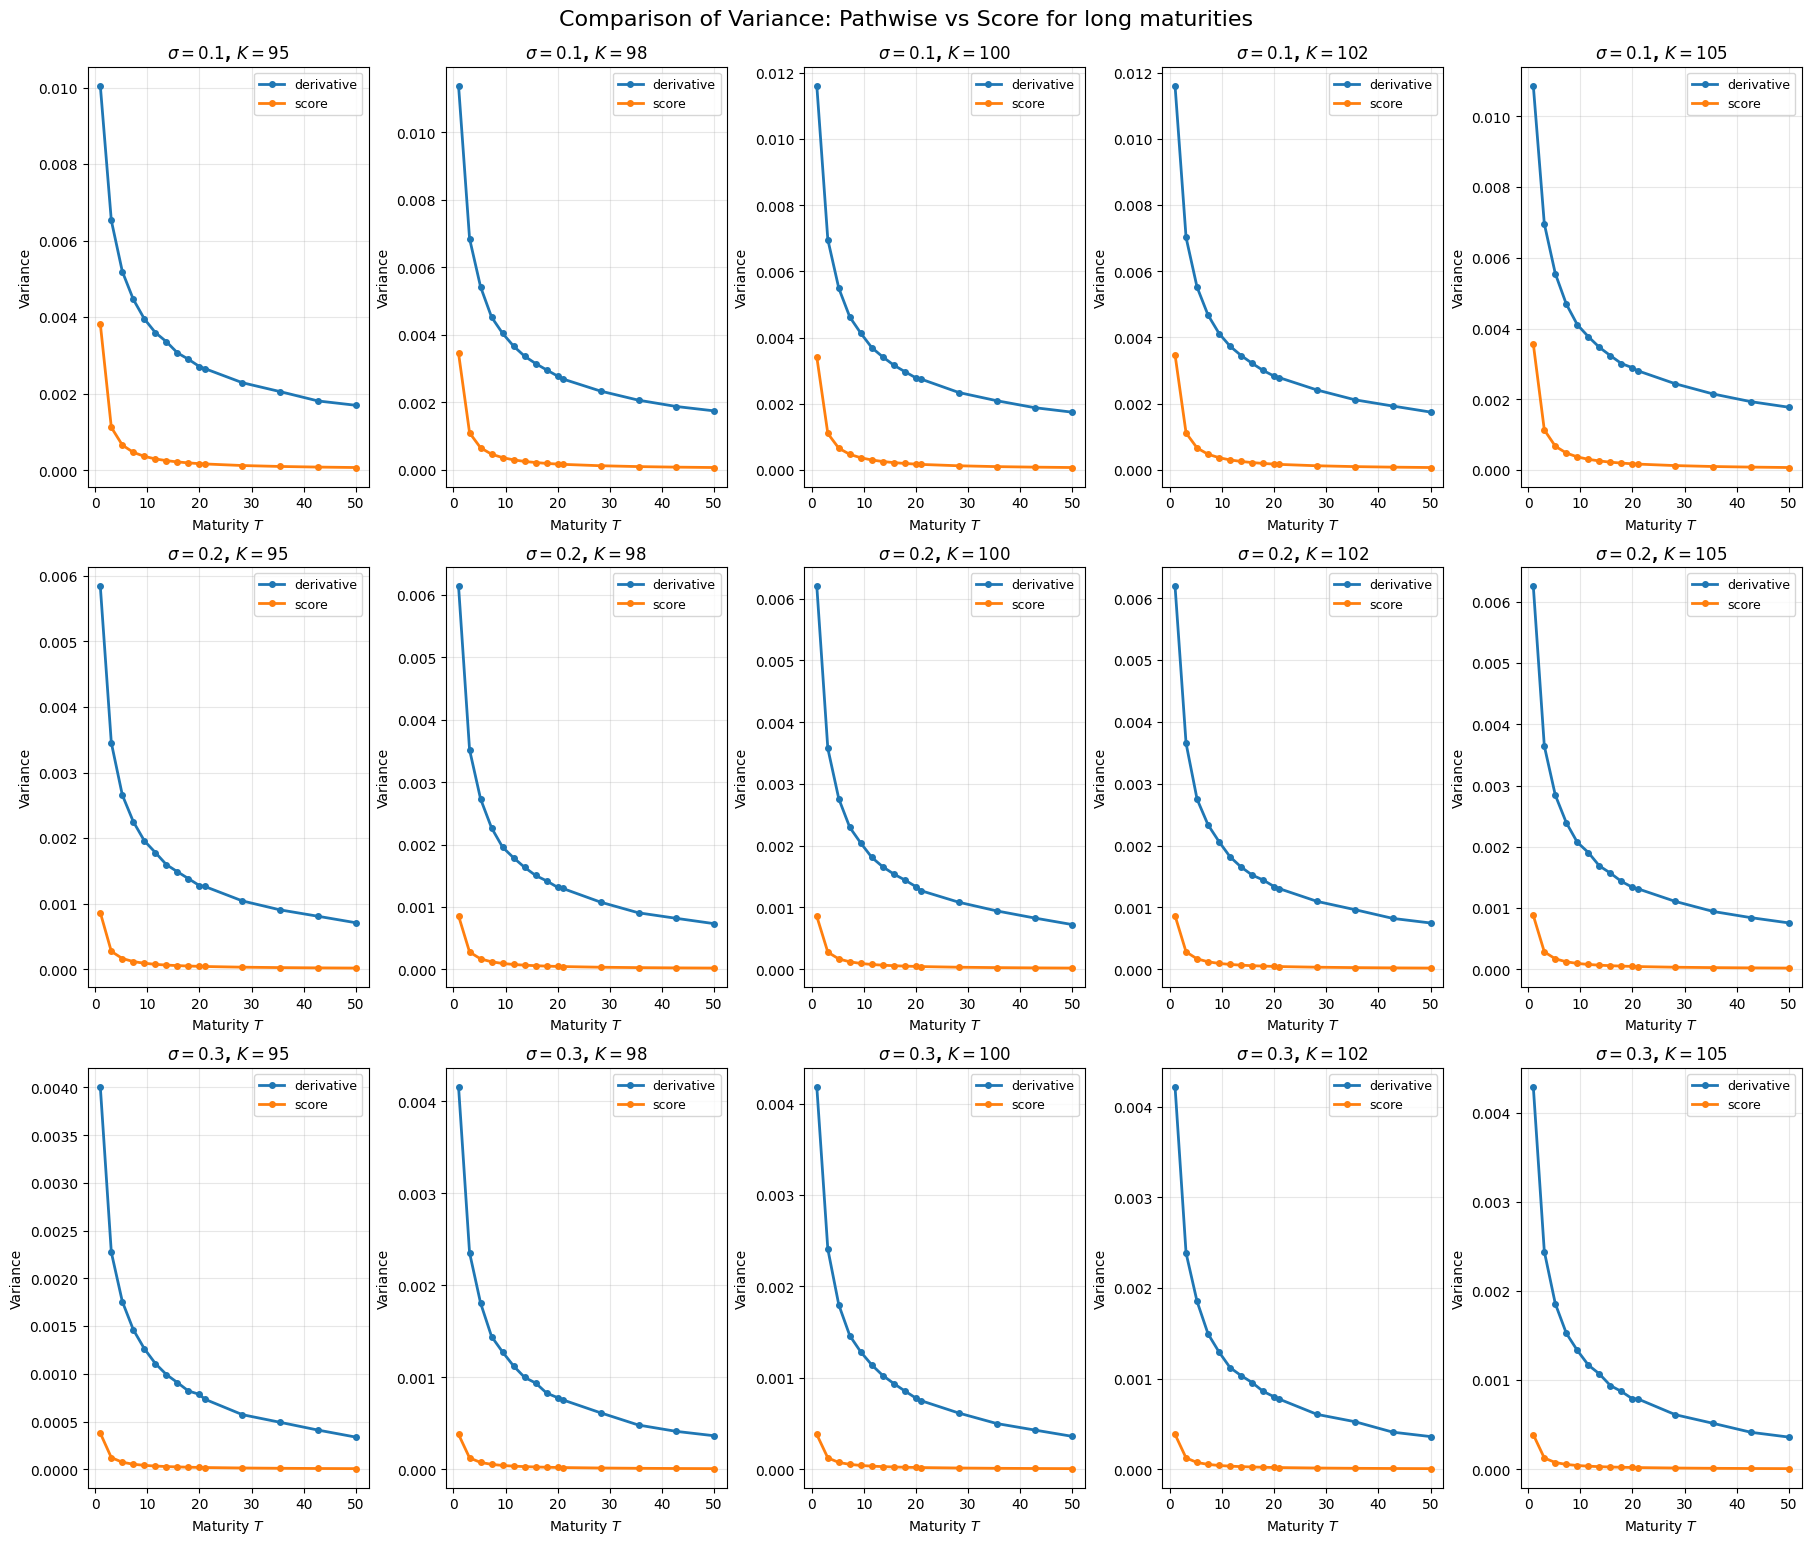

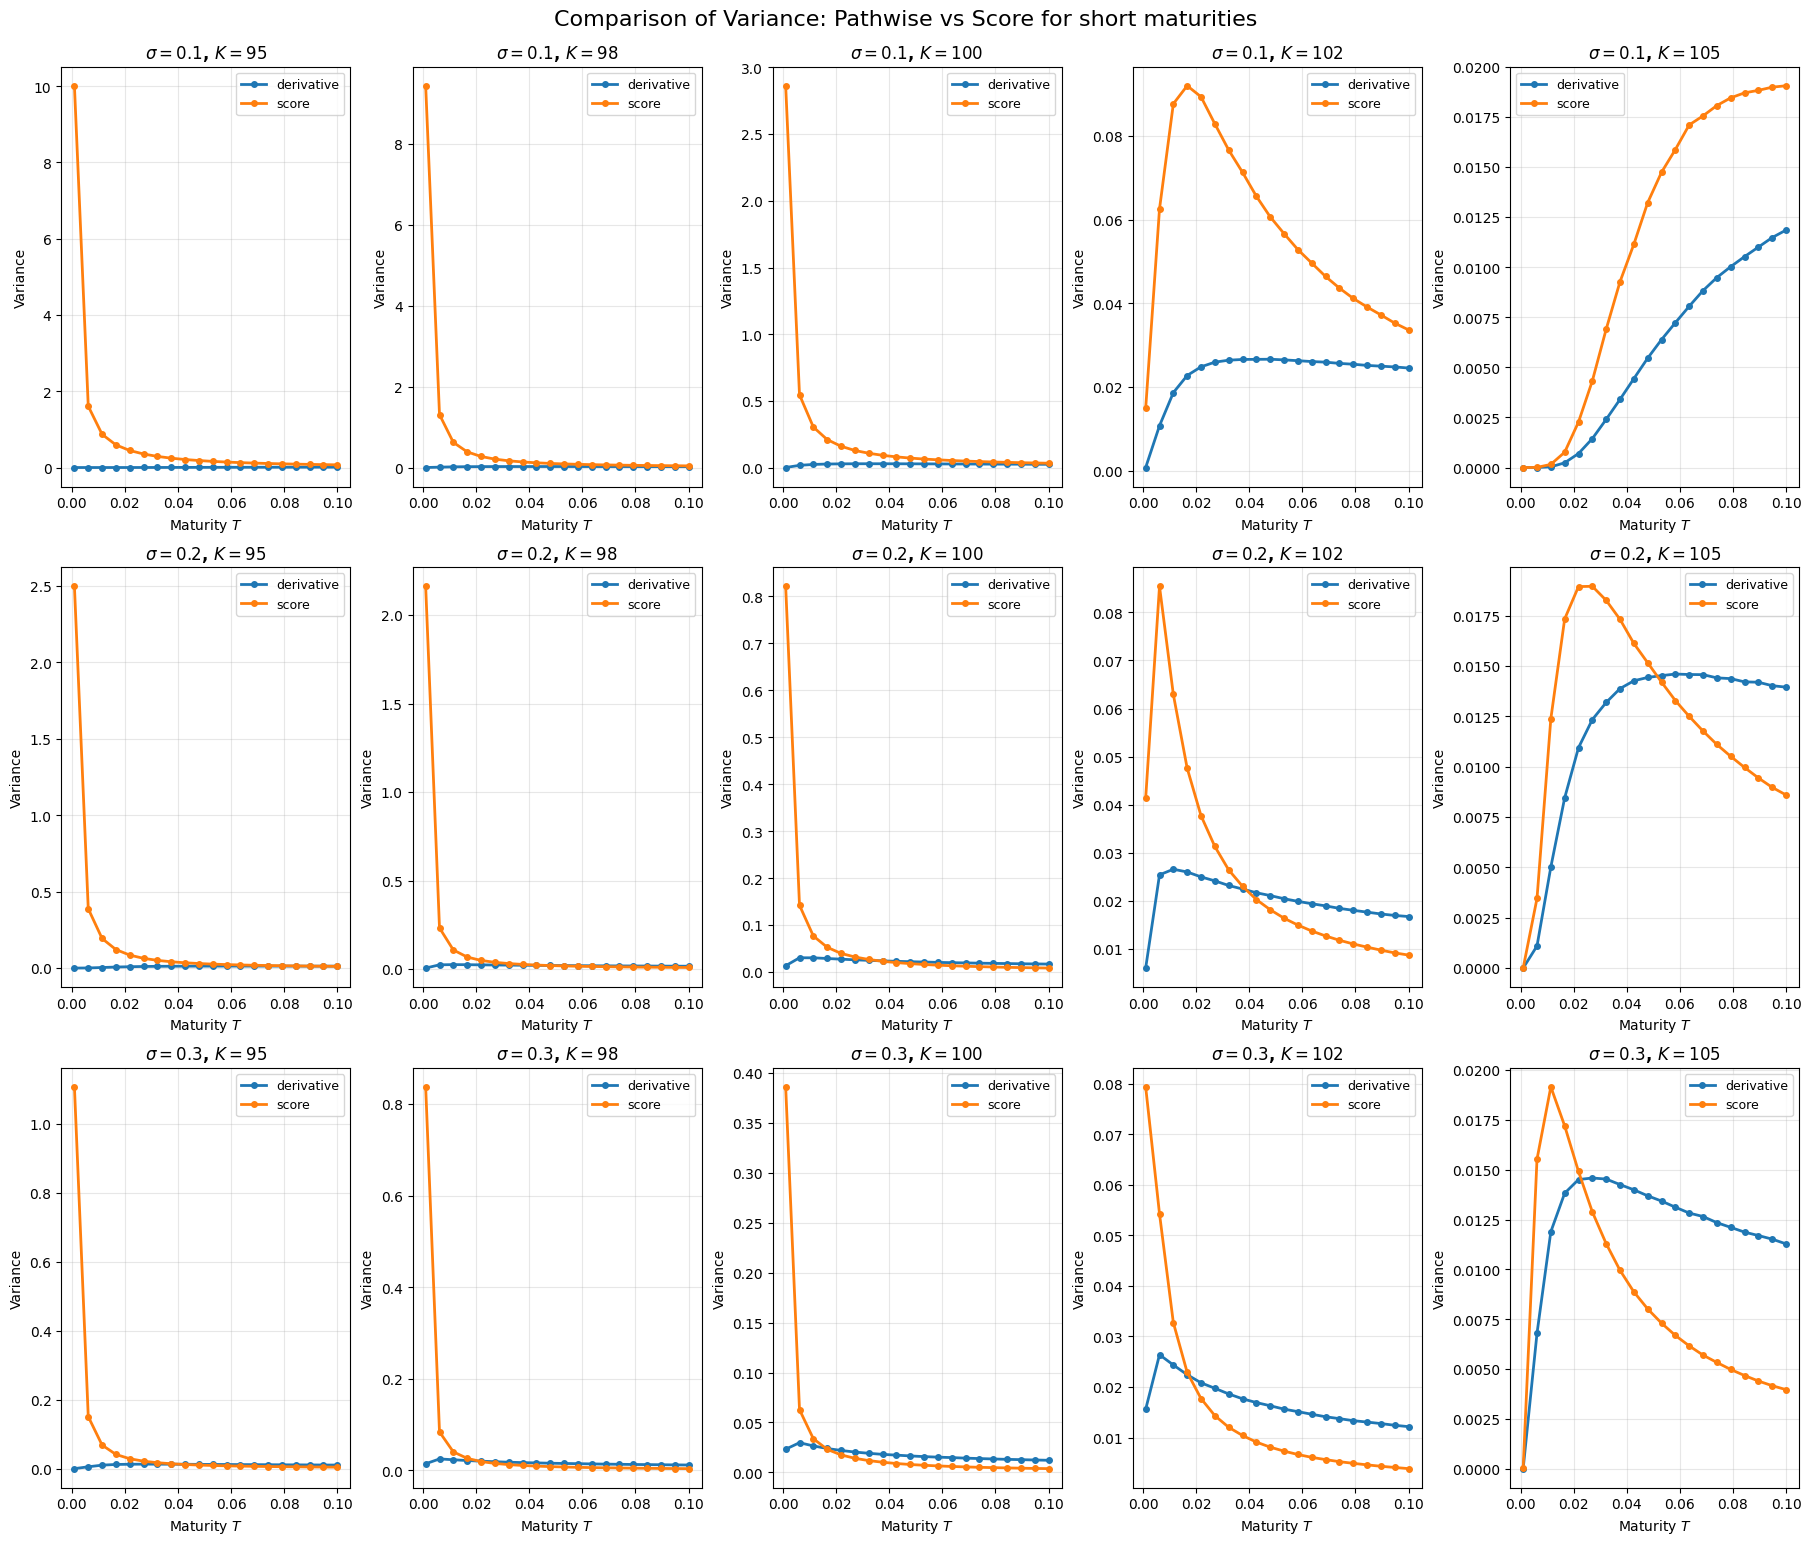

In [116]:
import matplotlib.pyplot as plt

# Params
sigmas = df_results["sigma"].unique()
Ks = [95, 98, 100, 102, 105]
scenarios = [(s, k) for s in sigmas for k in Ks]
n_plots = len(scenarios)

# Plotting grid for long maturities
n_cols = 5
n_rows = math.ceil(n_plots / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows), constrained_layout=True)

axes_flat = axes.flatten()

for i, (sigma, K) in enumerate(scenarios):
    ax = axes_flat[i]
    
    for method in df_results_smooth["method"].unique():
        # Filtering data
        subset = df_results_smooth[
            (df_results_smooth["sigma"] == sigma) & 
            (df_results_smooth["method"] == method) & 
            (df_results_smooth["K"] == K)
        ][20:]
        
        ax.plot(subset["T"], subset["var"], marker='o', label=method, linewidth=2, markersize=4)

    ax.set_title(f"$\sigma={sigma}$, $K={K}$", fontsize=12, fontweight='bold')
    ax.set_xlabel("Maturity $T$", fontsize=10)
    ax.set_ylabel("Variance", fontsize=10)
    ax.legend(fontsize=9)
    ax.grid(True, which="both", ls="-", alpha=0.3)

for j in range(i + 1, len(axes_flat)):
    fig.delaxes(axes_flat[j])

plt.suptitle("Comparison of Variance: Pathwise vs Score for long maturities", fontsize=16, y=1.02)
plt.show()

# Plotting grid for short maturities
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows), constrained_layout=True)
axes_flat = axes.flatten()

for i, (sigma, K) in enumerate(scenarios):
    ax = axes_flat[i]
    
    for method in df_results_smooth["method"].unique():
        # Filtering data
        subset = df_results_smooth[
            (df_results_smooth["sigma"] == sigma) & 
            (df_results_smooth["method"] == method) & 
            (df_results_smooth["K"] == K)
        ][:20]
        
        ax.plot(subset["T"], subset["var"], marker='o', label=method, linewidth=2, markersize=4)

    ax.set_title(f"$\sigma={sigma}$, $K={K}$", fontsize=12, fontweight='bold')
    ax.set_xlabel("Maturity $T$", fontsize=10)
    ax.set_ylabel("Variance", fontsize=10)
    ax.legend(fontsize=9)
    ax.grid(True, which="both", ls="-", alpha=0.3)

for j in range(i + 1, len(axes_flat)):
    fig.delaxes(axes_flat[j])

plt.suptitle("Comparison of Variance: Pathwise vs Score for short maturities", fontsize=16, y=1.02)
plt.show()

### Analysis of Simulation Results

The simulations perfectly corroborate the theoretical variance behavior of both estimators:

1.  **Short Maturities ($T \to 0$):**
    As shown in the first set of graphs, the **Score (Likelihood Ratio)** method (orange curve) is highly unstable for short maturities. We observe a variance explosion due to the $1/(\sigma T)$ term in the score weight. Conversely, the **Pathwise** estimator (blue curve) remains stable and bounded, making it the superior choice for short-term sensitivities.

2.  **Long Maturities ($T \to 50$):**
    Over long horizons, the hierarchy inverts. The variance of the **Pathwise** estimator becomes consistently higher than that of the Score method. The **Score** estimator converges more efficiently toward zero variance. This is because it benefits from the bounded nature of the Digital payoff, whereas the Pathwise estimator accumulates noise from the tangent process of the underlying asset over time.

**Conclusion:**
To minimize the standard error of the Monte Carlo simulation, an **adaptive approach** is optimal: use the **Pathwise** method for short maturities (avoiding the singularity) and the **Score** method for long maturities (leveraging stability).

## Conclusion 

* **Use Pathwise** for **smooth, unbounded payoffs** (Call, Put, Asian). Differentiating the payoff usually reduces the variance (e.g., $g'(S_T) \in \{0,1\}$ for a Call vs $g(S_T) \propto S_T$ for the Score). 
  *Additionally, this method remains stable for short maturities ($T \to 0$), whereas the Score estimator suffers from variance explosion due to the singularity of the density weight $\frac{1}{\sigma T}$.*

* **Use Score (LR)** for **discontinuous or bounded payoffs** (Digital/Binary), especially where Pathwise is not defined. It is also more robust for very long maturities if the payoff does not grow with $S_T$.
  *Since the differentiation operates on the probability density rather than the payoff function, this method works even for "black box" or non-differentiable payoffs where the Pathwise derivative would be a Dirac delta (leading to a biased zero result).*